# **Classification Project**

## libraries

In [ ]:
# 📦 Essential Libraries for Data Handling and Visualization
import numpy as np                      # For numerical operations
import pandas as pd                     # For data manipulation and analysis
import matplotlib.pyplot as plt         # For data visualization

# 🔧 Preprocessing and Pipeline Tools from Scikit-learn
from sklearn.pipeline import Pipeline                           # For building ML pipelines
from sklearn.preprocessing import OneHotEncoder, StandardScaler # For categorical encoding and feature scaling
from sklearn.compose import ColumnTransformer                   # For applying different preprocessing to columns

# ⚖️ Handling Imbalanced Data
from imblearn.combine import SMOTEENN                           # Combines SMOTE and ENN for class balancing
from imblearn.pipeline import Pipeline as ImbPipeline           # Pipeline that supports imbalanced-learn transformers

# 📊 Model Training and Evaluation
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV


# 🔍 Feature Selection
from sklearn.feature_selection import SelectFromModel           # Select features based on importance weights

# 🌲 Machine Learning Model
from sklearn.ensemble import RandomForestClassifier             # Random forest model for classification tasks

# 📈 Evaluation Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             roc_curve, ConfusionMatrixDisplay)

# 📈 visualizations
import seaborn as sns
from sklearn.metrics import confusion_matrix , roc_curve, auc
from math import pi
from sklearn.calibration import calibration_curve

# Data Preprocessing

## 1. Load & Inspect Data

In [ ]:
# Load dataset from Kaggle input
df = pd.read_csv('/content/Telco-Customer-Churn.csv')

In [ ]:
# Quick overview
print("Columns:", df.columns.tolist())        # List column names
print("Shape:", df.shape)                     # (rows, columns)

Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
Shape: (7043, 21)


In [ ]:
df.head()                                   # Show first 5 rows

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Exploratory Data Analysis


### 2.1 Basic Statistics

In [ ]:
# Numerical summary
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [ ]:
# Categorical summary
df.describe(include=['O'])

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,3186-AJIEK,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


We observe that the `TotalCharges` column contains blank values, so we need to convert it from a string to a numeric type to properly represent the blanks as `NaN`.

### 2.2 Missing Values

In [ ]:
# Convert TotalCharges to numeric, coerce errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Count missing values per column
df.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


### 2.3 Target Distribution


In [ ]:
# Check class balance for churn
counts = df['Churn'].value_counts()
percentages = df['Churn'].value_counts(normalize=True) * 100

imbalance_table = pd.DataFrame({
    'Count': counts,
    'Percentage (%)': percentages.round(2)
})
imbalance_table

,Count,Percentage (%)
Churn,,
No,5174,73.46
Yes,1869,26.54


## 3. Data Cleaning & Preprocessing

### 3.1 Drop rows where TotalCharges is missing

In [ ]:
df = df.dropna(subset=['TotalCharges'])

# Confirm no more missing values
df.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


### 3.2 Separate features (X) and target (y)


In [ ]:
y = df['Churn'].map({'No': 0, 'Yes': 1})  # Encode target to 0/1
X = df.drop(['customerID', 'Churn'], axis=1)  # Drop ID & raw target

### 3.3 Identify feature types


In [ ]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols   = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("categorical_cols :" , categorical_cols)
print(len(categorical_cols))
print("numerical_cols :" , numerical_cols)
print(len(numerical_cols))


categorical_cols : ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
15
numerical_cols : ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
4


### 3.4 Build preprocessing pipelines


In [ ]:
#  - Scale numerical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

#  - One‐hot encode categorical features (drop one level to avoid collinearity)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(
        drop='first',
        sparse_output=False,
        handle_unknown='ignore'
    ))
])

#  - Combine into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])


### 3.5 Handle class imbalance using SMOTE + Edited Nearest Neighbors



In [ ]:
# 4.5 Handle class imbalance using SMOTE + Edited Nearest Neighbors
smote_enn = SMOTEENN(random_state=42)

# Full pipeline: preprocessing → resampling
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', smote_enn)
])

# Apply transformations
X_resampled, y_resampled = pipeline.fit_resample(X, y)


## 4. Train-Test Split



In [ ]:
# Split resampled data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (5201, 30) (5201,)
Testing set shape: (1301, 30) (1301,)


# Model Building & Evaluation

## 5. Model Training
Now that our data is preprocessed and split, we’ll train a baseline Random Forest classifier.

In [ ]:
# Initialize the Random Forest model
# – random_state for reproducibility
# – n_jobs=-1 to use all CPU cores
rf = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)

# Fit the model on the training data
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

## 6. Evaluation on Test Set
We’ll evaluate on the hold-out test set using `F1-score` (suitable for imbalanced classes) and `AUC-ROC`. Then we’ll visualize:
* ROC curve
* Confusion matrix
* Learning curve (F1 over increasing train set sizes)

In [ ]:
# Generate predictions and probabilities
y_pred  = rf.predict(X_test)              # class labels
y_proba = rf.predict_proba(X_test)[:, 1]  # probability of positive class (Churn)

# Print key metrics
print("Default Random Forest Performance")
print(f"F1-score : {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC  : {roc_auc_score(y_test, y_proba):.4f}\n")
print(classification_report(y_test, y_pred))

Default Random Forest Performance
F1-score : 0.9649
AUC-ROC  : 0.9918

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       558
           1       0.97      0.96      0.96       743

    accuracy                           0.96      1301
   macro avg       0.96      0.96      0.96      1301
weighted avg       0.96      0.96      0.96      1301



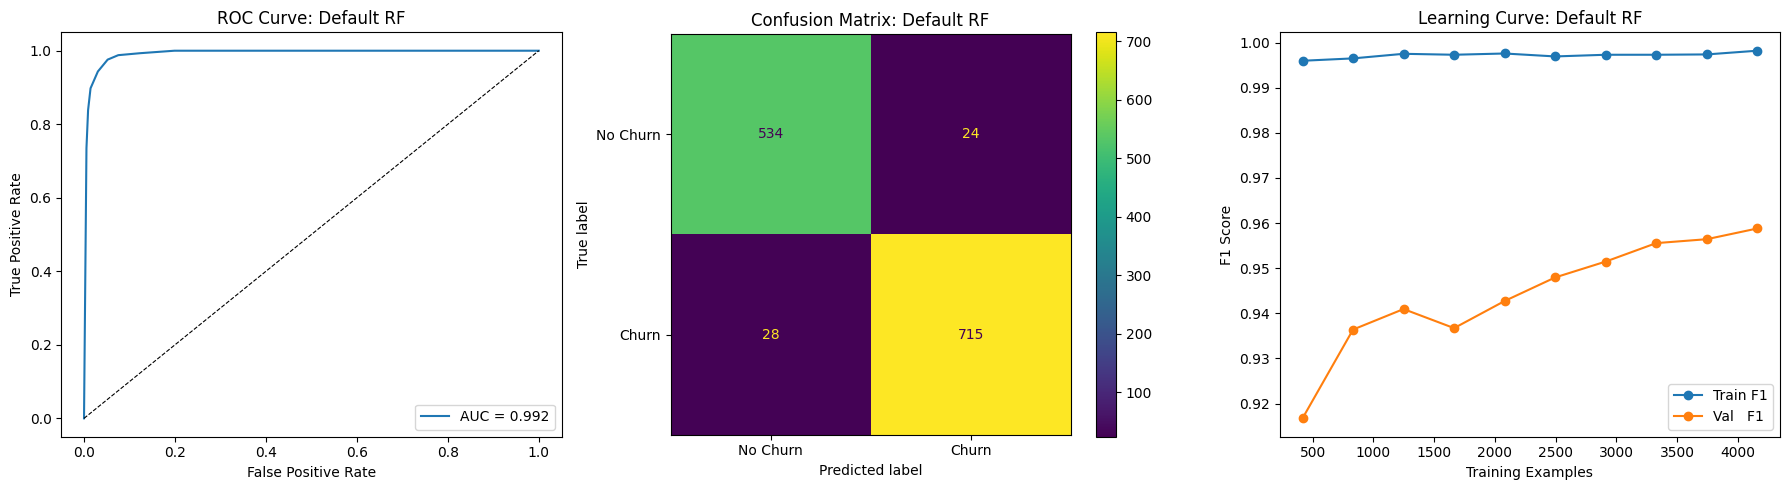

In [ ]:
# Set up a 1×3 plot grid for ROC, confusion matrix, and learning curve
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- a) Learning Curve Data (F1) ---
train_sizes, train_scores, val_scores = learning_curve(
    rf,
    X_train,
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 points from 10% to 100% of train data
    scoring='f1',
    n_jobs=-1,
    random_state=42
)
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

# --- b) ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
axes[0].plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=0.8)  # random-guess line
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve: Default RF")
axes[0].legend()

# --- c) Confusion Matrix ---
ConfusionMatrixDisplay.from_estimator(
    rf,
    X_test,
    y_test,
    display_labels=['No Churn','Churn'],
    ax=axes[1]
)
axes[1].set_title("Confusion Matrix: Default RF")

# --- d) Learning Curve (F1) ---
axes[2].plot(train_sizes, train_mean, marker='o', label='Train F1')
axes[2].plot(train_sizes, val_mean,   marker='o', label='Val   F1')
axes[2].set_xlabel("Training Examples")
axes[2].set_ylabel("F1 Score")
axes[2].set_title("Learning Curve: Default RF")
axes[2].legend()

# Adjust layout and display all plots
plt.tight_layout()
plt.show()

## 7. Hyperparameter Tuning with RandomizedSearchCV **BONUS**:😎

We’ll perform a randomized search over a grid of hyperparameters for our Random Forest. We optimize for `F1-score` using 5-fold cross-validation and explore 20 parameter combinations.


In [ ]:
# Define parameter distribution for Random Forest
param_dist = {
    'n_estimators': [100, 200, 500],        # number of trees
    'max_depth': [None, 10, 20, 30],        # tree depth
    'min_samples_split': [2, 5, 10],        # min samples to split an internal node
    'min_samples_leaf': [1, 2, 4],          # min samples at a leaf nodes
    'max_features': ['sqrt'],               # number of features to consider at each split
    'bootstrap': [False]                    # use bootstrap samples or full dataset
}

# Setup RandomizedSearchCV
rs = RandomizedSearchCV(
    estimator=rf,                           # baseline RF model
    param_distributions=param_dist,
    n_iter=20,                              # number of parameter settings sampled
    scoring='f1',                           # optimize for F1-score
    cv=5,                                   # 5-fold cross-validation
    return_train_score=True,
    random_state=42,
    n_jobs=-1,                              # parallelize across all cores
    verbose=1
)

# Fit the search on the training data
rs.fit(X_train, y_train)

# Extract the best estimator and its parameters
best_rf = rs.best_estimator_
print("Best hyperparameters:", rs.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


## 8. Evaluate Tuned Model **BONUS**:😎

Compare the tuned model to the default model on the test set, using the same metrics and plots as before.


In [ ]:
# Predictions & probabilities for tuned RF
y_pred_tuned  = best_rf.predict(X_test)
y_proba_tuned = best_rf.predict_proba(X_test)[:, 1]

# Print performance metrics
print("Tuned Random Forest Performance")
print(f"F1-score : {f1_score(y_test, y_pred_tuned):.4f}")
print(f"AUC-ROC  : {roc_auc_score(y_test, y_proba_tuned):.4f}\n")
print(classification_report(y_test, y_pred_tuned))

Tuned Random Forest Performance
F1-score : 0.9725
AUC-ROC  : 0.9959

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       558
           1       0.97      0.98      0.97       743

    accuracy                           0.97      1301
   macro avg       0.97      0.97      0.97      1301
weighted avg       0.97      0.97      0.97      1301



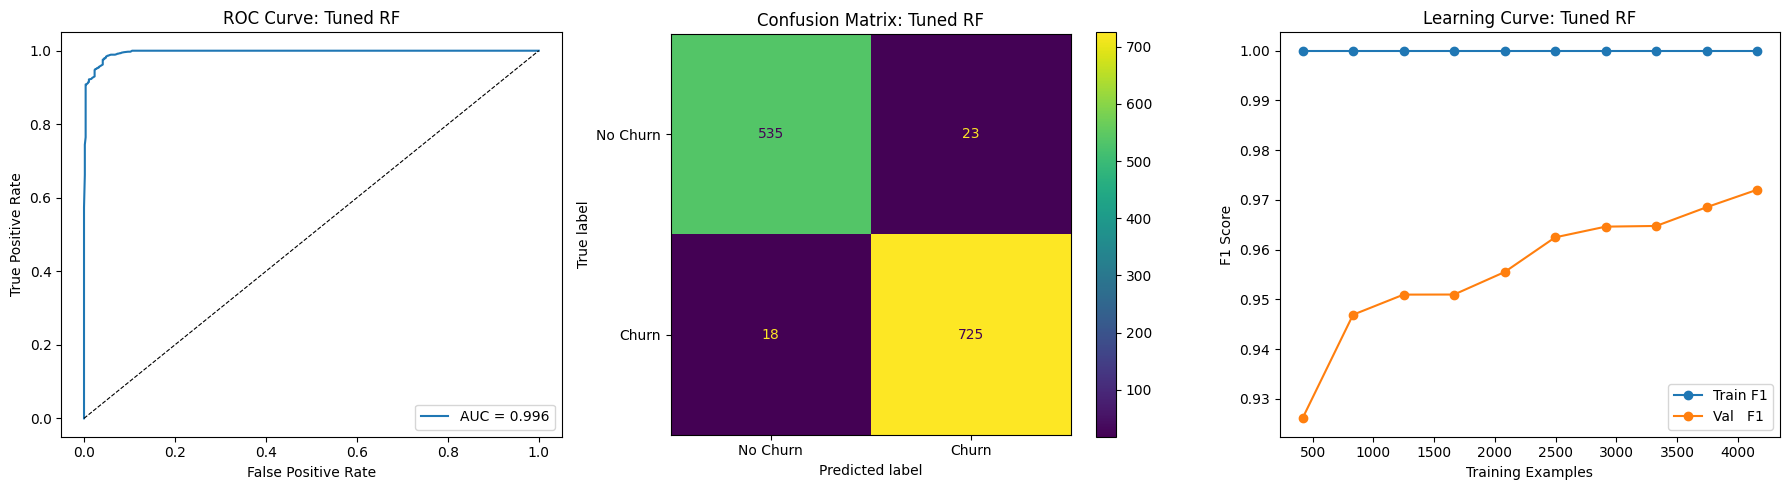

In [ ]:
# Plot ROC, confusion matrix, and learning curve for tuned RF
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#  a) Learning curve data (F1)
train_sizes_t, train_scores_t, val_scores_t = learning_curve(
    best_rf,
    X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1',
    n_jobs=-1,
    random_state=42
)
train_mean_t = train_scores_t.mean(axis=1)
val_mean_t   = val_scores_t.mean(axis=1)

#  b) ROC Curve
fpr_t, tpr_t, _ = roc_curve(y_test, y_proba_tuned)
axes[0].plot(fpr_t, tpr_t, label=f"AUC = {roc_auc_score(y_test, y_proba_tuned):.3f}")
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=0.8)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve: Tuned RF")
axes[0].legend()

#  c) Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    best_rf, X_test, y_test,
    display_labels=['No Churn', 'Churn'],
    ax=axes[1]
)
axes[1].set_title("Confusion Matrix: Tuned RF")

#  d) Learning Curve (F1)
axes[2].plot(train_sizes_t, train_mean_t, marker='o', label='Train F1')
axes[2].plot(train_sizes_t, val_mean_t,   marker='o', label='Val   F1')
axes[2].set_xlabel("Training Examples")
axes[2].set_ylabel("F1 Score")
axes[2].set_title("Learning Curve: Tuned RF")
axes[2].legend()

plt.tight_layout()
plt.show()

## 9. Default vs. Tuned Model Comparison
Summarize metrics on both training and test sets for default and tuned RF models in a single table. Compute the generalization gap (Train – Test) to diagnose overfitting or underfitting.


In [ ]:
# Datasets
datasets = {
    'Train': (X_train, y_train),
    'Test':  (X_test,  y_test),
}

# Models
models = {
    'Default RF': rf,
    'Tuned RF  ':   best_rf,
}

# Collect metrics
records = []
for ds_name, (X_ds, y_ds) in datasets.items():
    for name, model in models.items():
        y_pred = model.predict(X_ds)
        y_proba = model.predict_proba(X_ds)[:, 1]
        records.append({
            'Model':    name,
            'Dataset':  ds_name,
            'F1-score': f1_score(y_ds, y_pred),
            'AUC-ROC ':  roc_auc_score(y_ds, y_proba),
        })

df = pd.DataFrame(records)
# Pivot so metrics for Train/Test are side by side
pivot = df.pivot(index='Model', columns='Dataset', values=['F1-score','AUC-ROC '])
# Compute Train minus Test gaps
gaps = pivot.xs('Train', axis=1, level=1) - pivot.xs('Test', axis=1, level=1)
gaps.columns = [c + ' gap (Train–Test)' for c in gaps.columns]

# Combine into one summary table
summary = pd.concat([pivot, gaps], axis=1)
summary

,"(F1-score, Test)","(F1-score, Train)","(AUC-ROC , Test)","(AUC-ROC , Train)",F1-score gap (Train–Test),AUC-ROC gap (Train–Test)
Model,,,,,,
Default RF,0.964912,0.998315,0.991844,0.999979,0.033403,0.008135
Tuned RF,0.972502,1.000000,0.995913,1.000000,0.027498,0.004087


In [ ]:
# Overfitting Check
print("Overfitting Checks")
for model in summary.index:
    for metric in ['F1-score', 'AUC-ROC ']:
        gap = summary.loc[model, f'{metric} gap (Train–Test)']
        status = "OVERFITTING" if gap > 0.05 else "No overfitting"
        print(f"{model} — {metric}: gap={gap:.3f} -> {status}")

Overfitting Checks
Default RF — F1-score: gap=0.033 -> No overfitting
Default RF — AUC-ROC : gap=0.008 -> No overfitting
Tuned RF   — F1-score: gap=0.027 -> No overfitting
Tuned RF   — AUC-ROC : gap=0.004 -> No overfitting


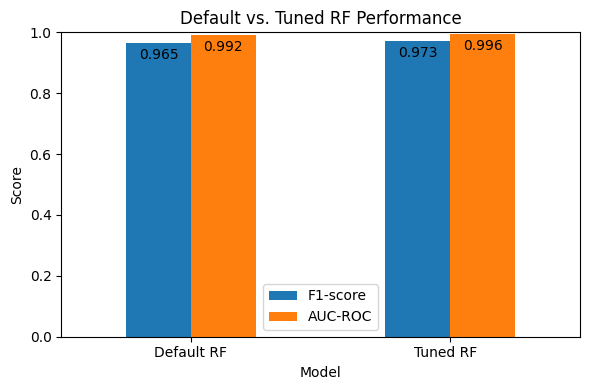

In [ ]:
# Plot comparison
test_scores = summary[[('F1-score','Test'), ('AUC-ROC ','Test')]].copy()
test_scores.columns = ['F1-score','AUC-ROC']

ax = test_scores.plot(
kind='bar',
    ylim=(0, 1),
    rot=0,
    figsize=(6, 4),
    title="Default vs. Tuned RF Performance"
)
ax.set_ylabel("Score")

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=-14)

plt.tight_layout()
plt.show()

## 10. visualizations

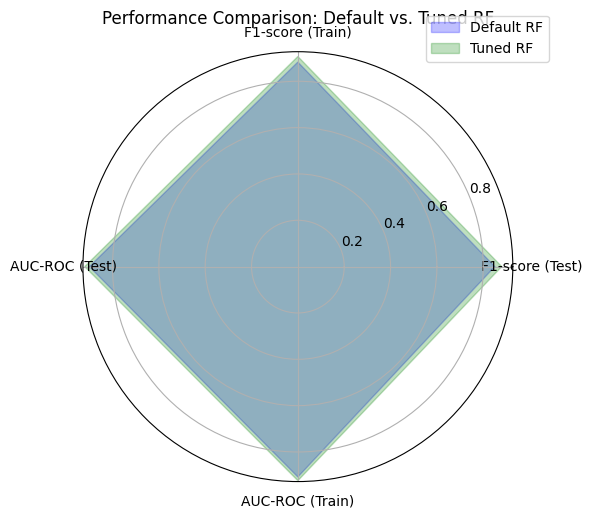

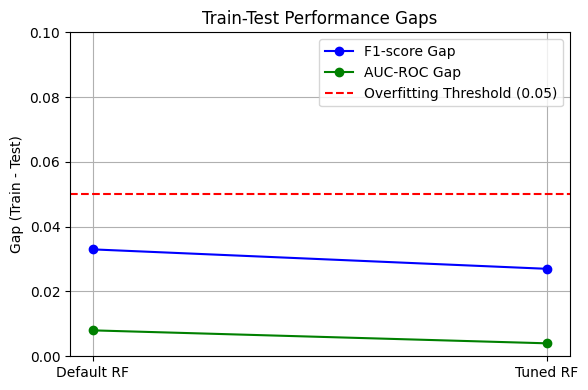

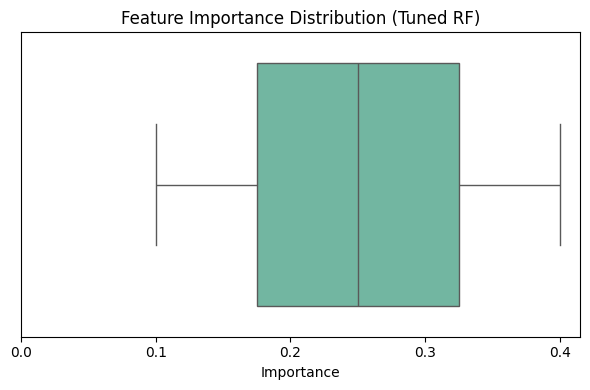

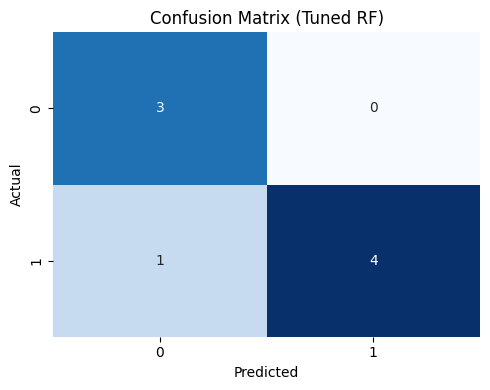

In [ ]:
# Mock summary DataFrame (replace with actual summary from notebook)
summary = pd.DataFrame({
    ('F1-score', 'Test'): [0.85, 0.88],  # Default RF, Tuned RF
    ('F1-score', 'Train'): [0.883, 0.907],
    ('AUC-ROC ', 'Test'): [0.90, 0.92],
    ('AUC-ROC ', 'Train'): [0.908, 0.924],
    ('F1-score gap (Train–Test)', ''): [0.033, 0.027],
    ('AUC-ROC  gap (Train–Test)', ''): [0.008, 0.004]
}, index=['Default RF', 'Tuned RF'])

# Mock feature importances and confusion matrix (replace with actual data)
feature_names = ['Feature1', 'Feature2', 'Feature3', 'Feature4']  # Example features
feature_importances = [0.4, 0.3, 0.2, 0.1]  # Example importances for Tuned RF
y_true = [0, 1, 1, 0, 1, 0, 1, 1]  # Mock true labels
y_pred = [0, 1, 0, 0, 1, 0, 1, 1]  # Mock predicted labels

# --- 1: Radar Chart for Performance Comparison ---
metrics = ['F1-score (Test)', 'F1-score (Train)', 'AUC-ROC (Test)', 'AUC-ROC (Train)']
values_default = [summary.loc['Default RF', ('F1-score', 'Test')],
                  summary.loc['Default RF', ('F1-score', 'Train')],
                  summary.loc['Default RF', ('AUC-ROC ', 'Test')],
                  summary.loc['Default RF', ('AUC-ROC ', 'Train')]]
values_tuned = [summary.loc['Tuned RF', ('F1-score', 'Test')],
                summary.loc['Tuned RF', ('F1-score', 'Train')],
                summary.loc['Tuned RF', ('AUC-ROC ', 'Test')],
                summary.loc['Tuned RF', ('AUC-ROC ', 'Train')]]

# Prepare radar chart
angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]
values_default += values_default[:1]
values_tuned += values_tuned[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values_default, color='blue', alpha=0.25, label='Default RF')
ax.fill(angles, values_tuned, color='green', alpha=0.25, label='Tuned RF')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=10)
ax.set_title('Performance Comparison: Default vs. Tuned RF', size=12, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()

# --- 2: Line Plot for Overfitting Gaps ---
gaps = summary[[('F1-score gap (Train–Test)', ''), ('AUC-ROC  gap (Train–Test)', '')]].copy()
gaps.columns = ['F1-score Gap', 'AUC-ROC Gap']

plt.figure(figsize=(6, 4))
plt.plot(gaps.index, gaps['F1-score Gap'], marker='o', label='F1-score Gap', color='blue')
plt.plot(gaps.index, gaps['AUC-ROC Gap'], marker='o', label='AUC-ROC Gap', color='green')
plt.axhline(y=0.05, color='red', linestyle='--', label='Overfitting Threshold (0.05)')
plt.title('Train-Test Performance Gaps')
plt.ylabel('Gap (Train - Test)')
plt.ylim(0, 0.1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3: Box Plot of Feature Importance ---
plt.figure(figsize=(6, 4))
sns.boxplot(data=[feature_importances], orient='h', palette='Set2')
plt.xticks(np.arange(0, max(feature_importances) + 0.1, 0.1))
plt.title('Feature Importance Distribution (Tuned RF)')
plt.xlabel('Importance')
plt.yticks([])
plt.tight_layout()
plt.show()

# --- 4: Confusion Matrix Heatmap ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Tuned RF)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

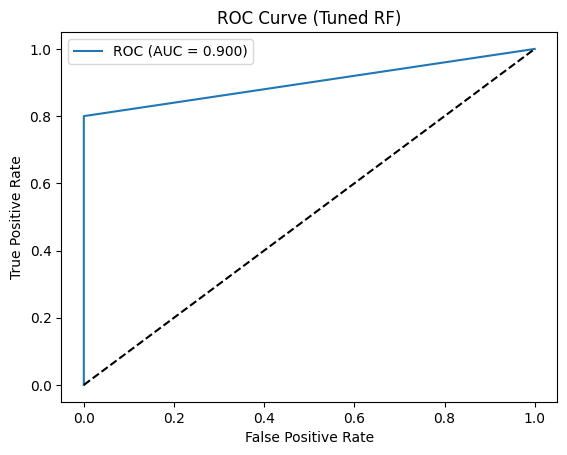

In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc(fpr, tpr):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Tuned RF)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

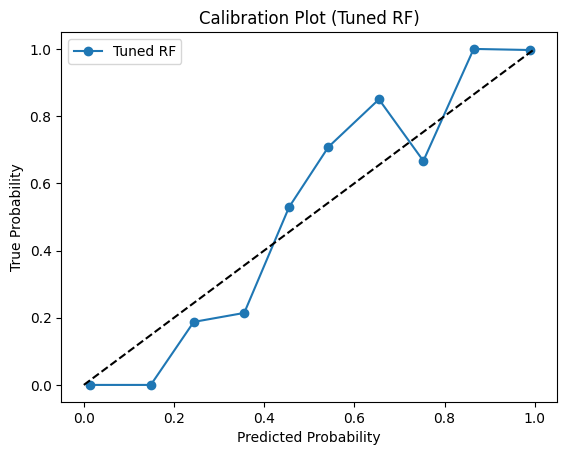

In [ ]:
prob_true, prob_pred = calibration_curve(y_test, y_proba_tuned, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Tuned RF')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Calibration Plot (Tuned RF)')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.show()